# `Consignment Price Prediction`

## `Problem Statement`

* The market for logistics analytics is expected to develop at a CAGR of 17.3 percent
  from 2019 to 2024, more than doubling in size. This data demonstrates how logistics
  organizations are understanding the advantages of being able to predict what will
  happen in the future with a decent degree of certainty. Logistics leaders may use this
  data to address supply chain difficulties, cut costs, and enhance service levels all at the
  same time. The main goal is to predict the consignment pricing based on the available factors in the
  dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#import mlflow
from scipy import stats
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from matplotlib.pyplot import figure


#mlflow.set_tracking_uri("sqlite:///consignment_price.db")
#mlflow.set_experiment("consignment-price-prediction")
warnings.filterwarnings('ignore')
pd.options.display.max_columns=None

### `Load data`

In [2]:
df = pd.read_csv('../data/SCMS_Delivery_History_Dataset.csv')

In [3]:
df.head()

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,NaN


In [4]:
df.columns

Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)'],
      dtype='object')

### `Explore the data`

<AxesSubplot:>

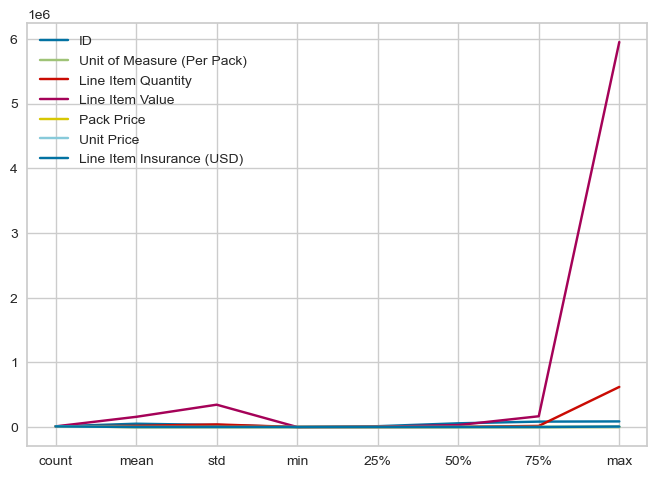

In [5]:
df.describe().plot.line()

In [6]:
df.describe()

,ID,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Line Item Insurance (USD)
count,10324.000000,10324.000000,10324.000000,1.032400e+04,10324.000000,10324.000000,10037.000000
mean,51098.968229,77.990895,18332.534870,1.576506e+05,21.910241,0.611701,240.117626
std,31944.332496,76.579764,40035.302961,3.452921e+05,45.609223,3.275808,500.190568
min,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,12795.750000,30.000000,408.000000,4.314593e+03,4.120000,0.080000,6.510000
50%,57540.500000,60.000000,3000.000000,3.047147e+04,9.300000,0.160000,47.040000
75%,83648.250000,90.000000,17039.750000,1.664471e+05,23.592500,0.470000,252.400000
max,86823.000000,1000.000000,619999.000000,5.951990e+06,1345.640000,238.650000,7708.440000


In [7]:
df.shape

(10324, 33)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10324 non-null  int64  
 1   Project Code                  10324 non-null  object 
 2   PQ #                          10324 non-null  object 
 3   PO / SO #                     10324 non-null  object 
 4   ASN/DN #                      10324 non-null  object 
 5   Country                       10324 non-null  object 
 6   Managed By                    10324 non-null  object 
 7   Fulfill Via                   10324 non-null  object 
 8   Vendor INCO Term              10324 non-null  object 
 9   Shipment Mode                 9964 non-null   object 
 10  PQ First Sent to Client Date  10324 non-null  object 
 11  PO Sent to Vendor Date        10324 non-null  object 
 12  Scheduled Delivery Date       10324 non-null  object 
 13  D

In [9]:
df.nunique()

ID                              10324
Project Code                      142
PQ #                             1237
PO / SO #                        6233
ASN/DN #                         7030
Country                            43
Managed By                          4
Fulfill Via                         2
Vendor INCO Term                    8
Shipment Mode                       4
PQ First Sent to Client Date      765
PO Sent to Vendor Date            897
Scheduled Delivery Date          2006
Delivered to Client Date         2093
Delivery Recorded Date           2042
Product Group                       5
Sub Classification                  6
Vendor                             73
Item Description                  184
Molecule/Test Type                 86
Brand                              48
Dosage                             54
Dosage Form                        17
Unit of Measure (Per Pack)         31
Line Item Quantity               5065
Line Item Value                  8741
Pack Price  

In [10]:
df.isna().sum()

ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                    360
PQ First Sent to Client Date       0
PO Sent to Vendor Date             0
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

### `Handling Null values`

In [11]:
def null_values(df, feature):
    match feature:
        case 'Line Item Insurance (USD)':
            df[feature] = df[feature].fillna(df['Line Item Insurance (USD)'].median())
            return df
        case 'Shipment Mode':
            df[feature]=df[feature].fillna("Other")
            return df
        case _:
            print('Error')

In [12]:
null_values(df, 'Line Item Insurance (USD)')
null_values(df, 'Shipment Mode')

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13,780.34,47.04
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358,4521.5,47.04
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171,1653.78,47.04
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855,16007.06,47.04
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590,45450.08,47.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO-50020,DN-4307,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,See DN-4307 (ID#:83920),See DN-4307 (ID#:83920),705.79
10320,86819,104-CI-T30,FPQ-15259,SO-50102,DN-4313,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/14,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,See DN-4313 (ID#:83921),See DN-4313 (ID#:83921),161.71
10321,86821,110-ZM-T30,FPQ-14784,SO-49600,DN-4316,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/14,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,Weight Captured Separately,Freight Included in Commodity Cost,5284.04
10322,86822,200-ZW-T30,FPQ-16523,SO-51680,DN-4334,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/15,N/A - From RDC,9-Sep-15,4-Aug-15,11-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,

In [13]:
df.isna().sum()

ID                                 0
Project Code                       0
PQ #                               0
PO / SO #                          0
ASN/DN #                           0
Country                            0
Managed By                         0
Fulfill Via                        0
Vendor INCO Term                   0
Shipment Mode                      0
PQ First Sent to Client Date       0
PO Sent to Vendor Date             0
Scheduled Delivery Date            0
Delivered to Client Date           0
Delivery Recorded Date             0
Product Group                      0
Sub Classification                 0
Vendor                             0
Item Description                   0
Molecule/Test Type                 0
Brand                              0
Dosage                          1736
Dosage Form                        0
Unit of Measure (Per Pack)         0
Line Item Quantity                 0
Line Item Value                    0
Pack Price                         0
U

### `Data Cleaning part_1`

In [14]:
def replace_strings(df, feature):
    match feature:
        case 'Freight Cost (USD)':
            df[feature]=df[feature].replace("Freight Included in Commodity Cost",0)
            df.loc[df[feature].str.contains('See', na=False), feature] = 'test'
            df[feature] = df[feature].replace('test', 0)
            return df
        case 'Weight (Kilograms)':
            df[feature] = df[feature].replace('Weight Captured Separately', 0)
            df.loc[df[feature].str.contains('See', na=False), feature] = 'test'
            df[feature] = df[feature].replace('test', 0)
            return df
        case 'PO / SO #':
            df.loc[df[feature].str.contains('SCMS', na=False), feature] = 'SCMS'
            df.loc[df[feature].str.contains('SO', na=False), feature] = 'SO'
            return df
        case 'ASN/DN #':
            df.loc[df[feature].str.contains('ASN', na=False), feature] = 'ASN'
            df.loc[df[feature].str.contains('DN', na=False), feature] = 'DN'
        case _:
            print('Error')

In [15]:
replace_strings(df, 'Freight Cost (USD)')
replace_strings(df, 'Weight (Kilograms)')
replace_strings(df, 'PO / SO #')
replace_strings(df, 'ASN/DN #')

In [16]:
df.nunique()

ID                              10324
Project Code                      142
PQ #                             1237
PO / SO #                           3
ASN/DN #                            2
Country                            43
Managed By                          4
Fulfill Via                         2
Vendor INCO Term                    8
Shipment Mode                       5
PQ First Sent to Client Date      765
PO Sent to Vendor Date            897
Scheduled Delivery Date          2006
Delivered to Client Date         2093
Delivery Recorded Date           2042
Product Group                       5
Sub Classification                  6
Vendor                             73
Item Description                  184
Molecule/Test Type                 86
Brand                              48
Dosage                             54
Dosage Form                        17
Unit of Measure (Per Pack)         31
Line Item Quantity               5065
Line Item Value                  8741
Pack Price  

In [17]:
df['PO / SO #'].value_counts()

SO            5404
SCMS          4919
DSCM-10090       1
Name: PO / SO #, dtype: int64

In [18]:
df = df[df["PO / SO #"] != 'DSCM-10090']

In [19]:
df=df[(df["Freight Cost (USD)"]!='Invoiced Separately')]

In [20]:
df.shape

(10084, 33)

In [21]:
df['Freight Cost (USD)'].value_counts()

0           3887
9736.1        36
6147.18       27
7445.8        16
13398.06      16
            ... 
36096.76       1
52057.8        1
4312.92        1
25129.15       1
3410           1
Name: Freight Cost (USD), Length: 5432, dtype: int64

In [22]:
df['Freight Cost (USD)'] = df['Freight Cost (USD)'].astype('float')

In [23]:
df['Weight (Kilograms)'] = df['Weight (Kilograms)'].astype('float')

In [24]:
df['ASN/DN #'].unique()

array(['ASN', 'DN'], dtype=object)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10084 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            10084 non-null  int64  
 1   Project Code                  10084 non-null  object 
 2   PQ #                          10084 non-null  object 
 3   PO / SO #                     10084 non-null  object 
 4   ASN/DN #                      10084 non-null  object 
 5   Country                       10084 non-null  object 
 6   Managed By                    10084 non-null  object 
 7   Fulfill Via                   10084 non-null  object 
 8   Vendor INCO Term              10084 non-null  object 
 9   Shipment Mode                 10084 non-null  object 
 10  PQ First Sent to Client Date  10084 non-null  object 
 11  PO Sent to Vendor Date        10084 non-null  object 
 12  Scheduled Delivery Date       10084 non-null  object 
 13  D

# `EDA`

In [26]:
df['Shipment Mode'].value_counts(normalize=True) * 100

Air            58.726696
Truck          27.746926
Air Charter     6.426021
Other           3.570012
Ocean           3.530345
Name: Shipment Mode, dtype: float64

In [27]:
def value_count_norm(df, feature):
    value_count = df[feature].value_counts()
    value_count_norm_1 = df[feature].value_counts(normalize=True) * 100
    value_count_norm_1_concat = pd.concat([value_count, value_count_norm_1], axis=1)
    value_count_norm_1_concat.columns = ['Count', 'Frequency %']
    return value_count_norm_1_concat

In [28]:
def create_bar_plot(df, feature):
    sns.barplot(x=value_count_norm(df, feature).index, y=value_count_norm(df, feature).iloc[:, 0])
    plt.title('{}'.format(feature))
    return plt.show()

In [29]:
def create_hist_plot(df, feature):
    sns.histplot(df[feature])
    plt.title('{}'.format(feature))
    return plt.show()

In [30]:
len(value_count_norm(df, 'Fulfill Via').index)

2

In [31]:
def create_pie_chart(df, feature):
    n = len(value_count_norm(df, feature).index)
    colors = sns.color_palette('pastel')[0:n]
    plt.pie(value_count_norm(df, feature).iloc[:, 1],
            colors = colors, autopct='%1.2f%%', 
            labels=value_count_norm(df, feature).index)
    plt.title('{}'.format(feature))
    return plt.show()

In [32]:
def get_info(df, feature):
    match feature:
        case 'Line Item Insurance (USD)' | 'Freight Cost (USD)' | 'Consiment_price' | 'Weight (Kilograms)' | 'Line Item Quantity':
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case 'Shipment Mode' | 'Fulfill Via' | 'First Line Designation' | 'Vendor INCO Term' | 'Sub Classification' | 'Managed By' | 'PO / SO #' | 'ASN/DN #':
            #print('Description:\n{}'.format(df([feature]).describe())
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            print('Value count:\n{}'.format(value_count_norm(df, feature)))
        case _:
            print('Error')

In [34]:
def get_report(df, feature):
    match feature:
        case 'Fulfill Via' | 'First Line Designation' | 'PO / SO #' | 'ASN/DN #':
            get_info(df, feature)
            print('*'*50)
            create_pie_chart(df, feature)
        case 'Shipment Mode' | 'Vendor INCO Term' | 'Sub Classification' | 'Managed By':
            get_info(df, feature)
            print('*'*50)
            create_bar_plot(df, feature)
        case 'Line Item Insurance (USD)' | 'Freight Cost (USD)' | 'Consiment_price' | 'Weight (Kilograms)' | 'Line Item Quantity' :
            get_info(df, feature)
            print('*'*50)
            create_hist_plot(df, feature)
        case _:
            print("Error")
            

Description:
count        10084
unique           2
top       From RDC
freq          5328
Name: Fulfill Via, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
             Count  Frequency %
From RDC      5328    52.836176
Direct Drop   4756    47.163824
**************************************************


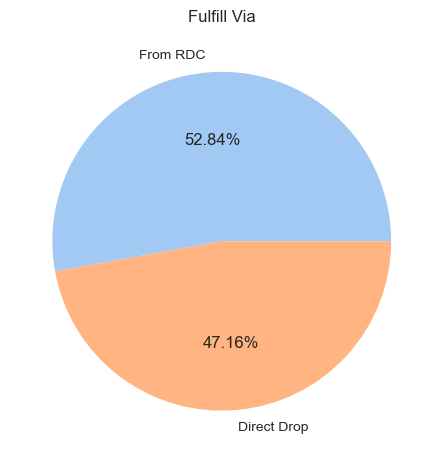

In [35]:
get_report(df, 'Fulfill Via')

Description:
count     10084
unique        2
top          DN
freq       5328
Name: ASN/DN #, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
     Count  Frequency %
DN    5328    52.836176
ASN   4756    47.163824
**************************************************


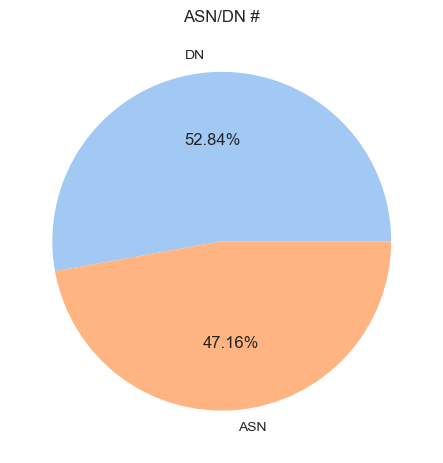

In [36]:
get_report(df, 'ASN/DN #')

Description:
count        10084
unique           4
top       PMO - US
freq         10025
Name: Managed By, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                           Count  Frequency %
PMO - US                   10025    99.414915
South Africa Field Office     57     0.565252
Haiti Field Office             1     0.009917
Ethiopia Field Office          1     0.009917
**************************************************


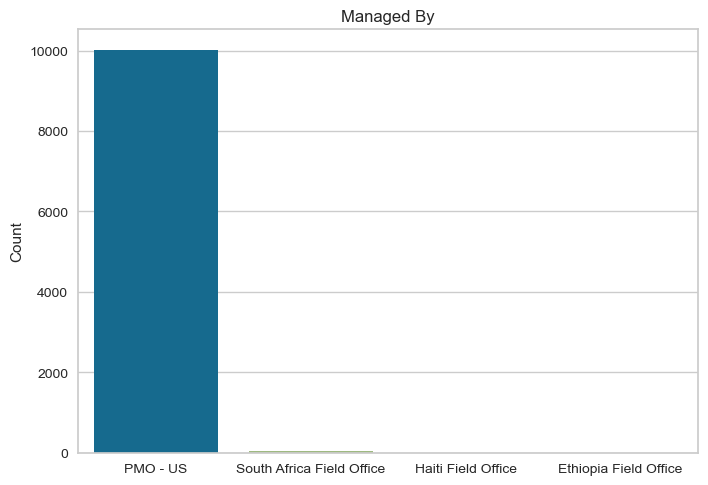

In [37]:
get_report(df, 'Managed By')

Description:
count     10084
unique        2
top         Yes
freq       6790
Name: First Line Designation, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
     Count  Frequency %
Yes   6790    67.334391
No    3294    32.665609
**************************************************


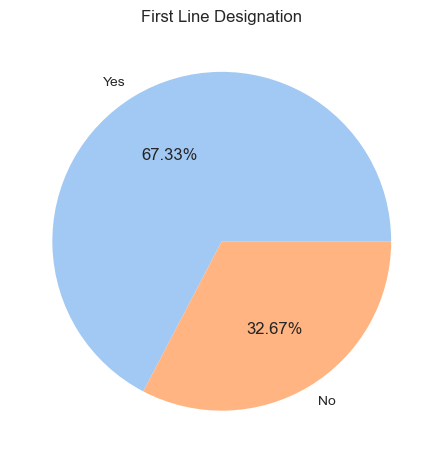

In [38]:
get_report(df, 'First Line Designation')

Description:
count     10084
unique        2
top          SO
freq       5328
Name: PO / SO #, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
      Count  Frequency %
SO     5328    52.836176
SCMS   4756    47.163824
**************************************************


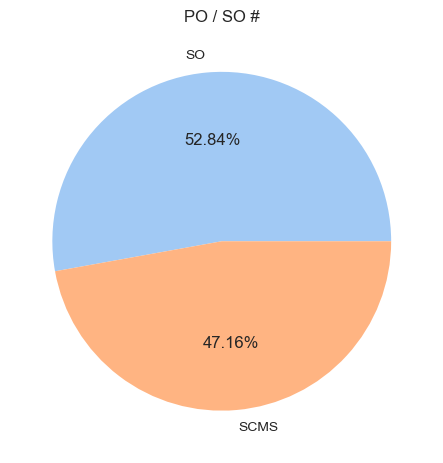

In [39]:
get_report(df, 'PO / SO #')

Description:
count              10084
unique                 8
top       N/A - From RDC
freq                5328
Name: Vendor INCO Term, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                Count  Frequency %
N/A - From RDC   5328    52.836176
EXW              2639    26.170171
DDP              1443    14.309798
FCA               372     3.689012
CIP               275     2.727092
DDU                15     0.148750
DAP                 9     0.089250
CIF                 3     0.029750
**************************************************


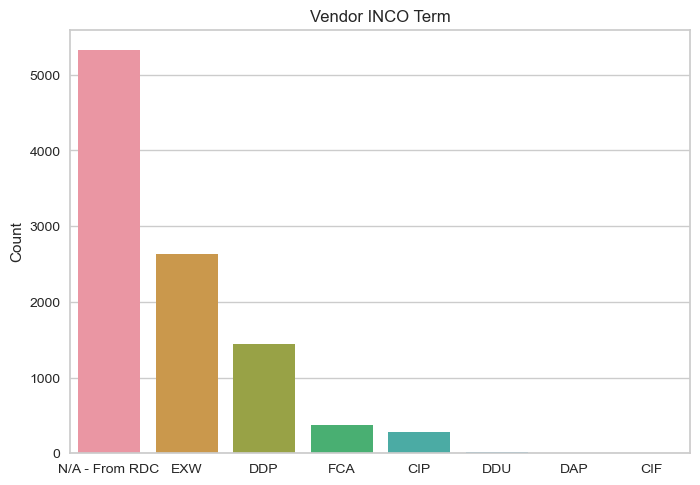

In [40]:
get_report(df, 'Vendor INCO Term')

Description:
count     10084
unique        6
top       Adult
freq       6486
Name: Sub Classification, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency %
Adult                  6486    64.319714
Pediatric              1914    18.980563
HIV test               1510    14.974217
HIV test - Ancillary    129     1.279254
Malaria                  29     0.287584
ACT                      16     0.158667
**************************************************


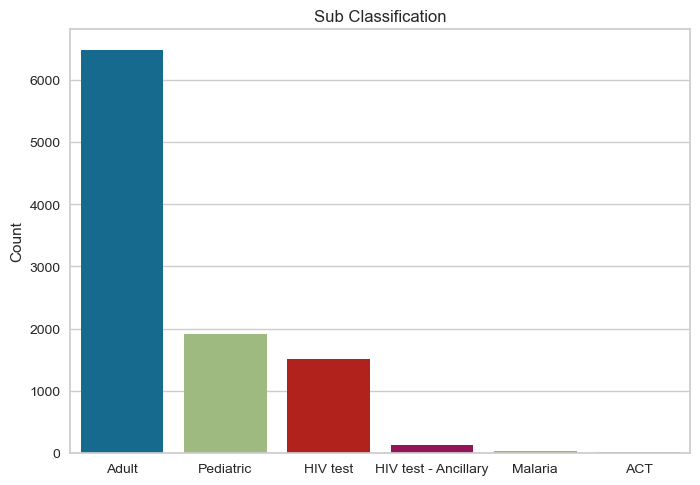

In [41]:
get_report(df, 'Sub Classification')

Description:
count     10084
unique        5
top         Air
freq       5922
Name: Shipment Mode, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
             Count  Frequency %
Air           5922    58.726696
Truck         2798    27.746926
Air Charter    648     6.426021
Other          360     3.570012
Ocean          356     3.530345
**************************************************


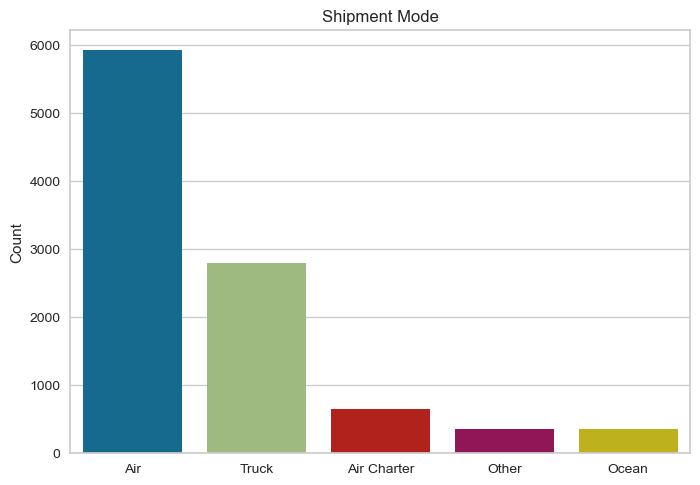

In [42]:
get_report(df, 'Shipment Mode')

Description:
count     10084.000000
mean       2162.121380
std       10877.957251
min           0.000000
25%           0.000000
50%         146.000000
75%        1671.000000
max      857354.000000
Name: Weight (Kilograms), dtype: float64
**************************************************
Object type:float64
**************************************************


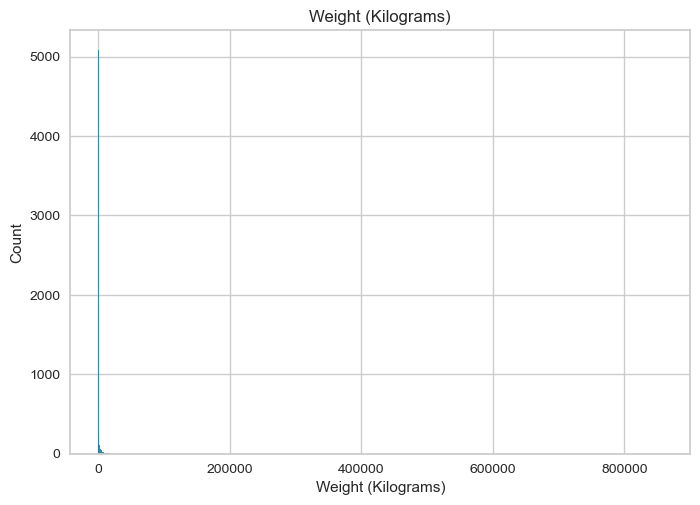

In [43]:
get_report(df, 'Weight (Kilograms)')

Description:
count     10084.000000
mean       6822.375411
std       13522.921939
min           0.000000
25%           0.000000
50%        1583.545000
75%        7962.252500
max      289653.200000
Name: Freight Cost (USD), dtype: float64
**************************************************
Object type:float64
**************************************************


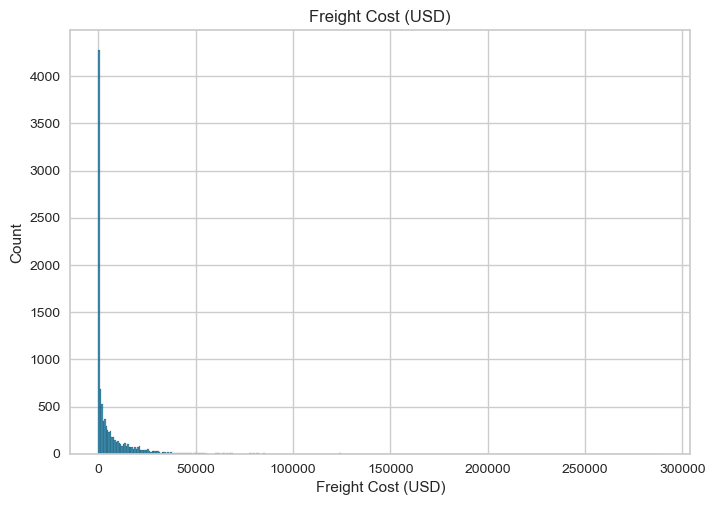

In [44]:
get_report(df, 'Freight Cost (USD)')

sns.regplot(x='Consiment_price', y='Line Item Insurance (USD)', data=df, line_kws={'color':'red'},scatter_kws={'alpha':0.5})

sns.regplot(x='Consiment_price', y='Line Item Value', data=df, line_kws={'color':'red'},scatter_kws={'alpha':0.5})

<AxesSubplot:xlabel='Dosage'>

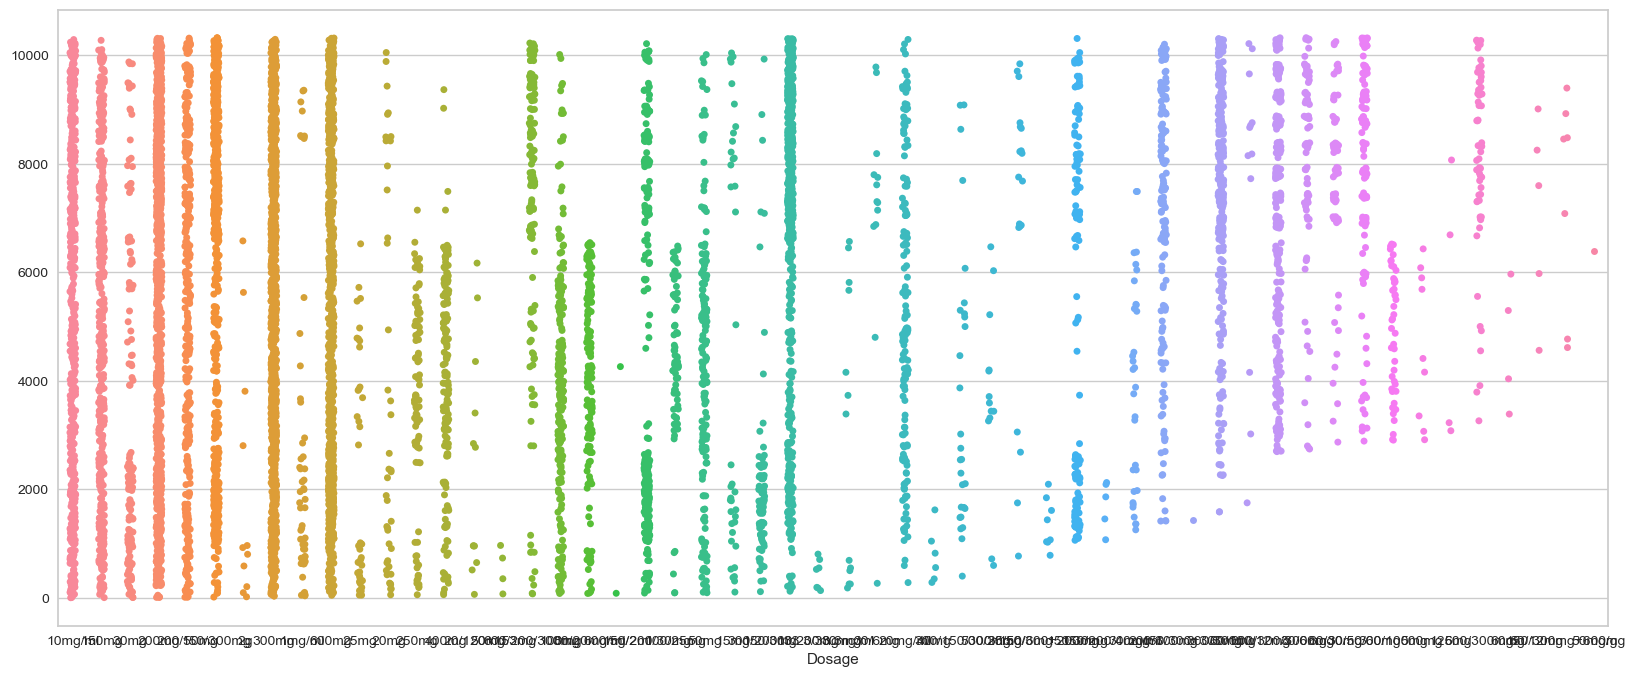

In [45]:
figure(figsize=(20, 8))
sns.stripplot(x=df['Dosage'], y=df.index)

<AxesSubplot:>

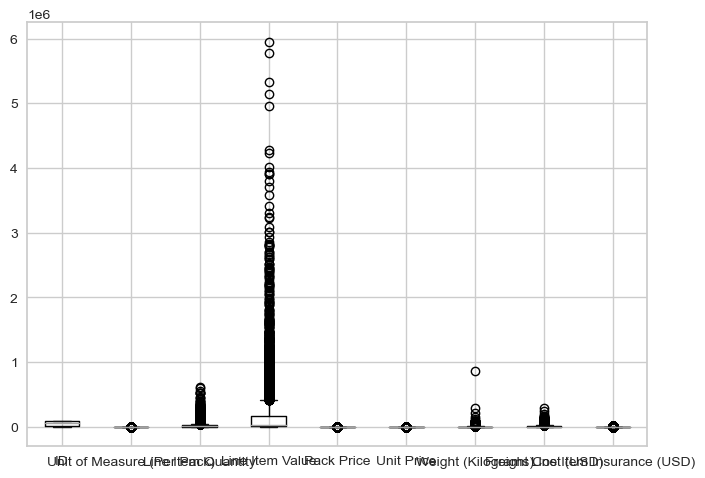

In [46]:
df.boxplot()

In [47]:
df

,ID,Project Code,PQ #,PO / SO #,ASN/DN #,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,PQ First Sent to Client Date,PO Sent to Vendor Date,Scheduled Delivery Date,Delivered to Client Date,Delivery Recorded Date,Product Group,Sub Classification,Vendor,Item Description,Molecule/Test Type,Brand,Dosage,Dosage Form,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Manufacturing Site,First Line Designation,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD)
0,1,100-CI-T01,Pre-PQ Process,SCMS,ASN,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,2-Jun-06,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...","HIV, Reveal G3 Rapid HIV-1 Antibody Test",Reveal,NaN,Test kit,30,19,551.00,29.00,0.97,Ranbaxy Fine Chemicals LTD,Yes,13.0,780.34,47.04
1,3,108-VN-T01,Pre-PQ Process,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,14-Nov-06,14-Nov-06,14-Nov-06,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",Nevirapine,Generic,10mg/ml,Oral suspension,240,1000,6200.00,6.20,0.03,"Aurobindo Unit III, India",Yes,358.0,4521.50,47.04
2,4,100-CI-T01,Pre-PQ Process,SCMS,ASN,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,Date Not Captured,27-Aug-06,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,NaN,Test kit,100,500,40000.00,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,Yes,171.0,1653.78,47.04
3,15,108-VN-T01,Pre-PQ Process,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,1-Sep-06,1-Sep-06,1-Sep-06,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",Lamivudine,Generic,150mg,Tablet,60,31920,127360.80,3.99,0.07,"Ranbaxy, Paonta Shahib, India",Yes,1855.0,16007.06,47.04
4,16,108-VN-T01,Pre-PQ Process,SCMS,ASN,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,Date Not Captured,11-Aug-06,11-Aug-06,11-Aug-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",Stavudine,Generic,30mg,Capsule,60,38000,121600.00,3.20,0.05,"Aurobindo Unit III, India",Yes,7590.0,45450.08,47.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,86818,103-ZW-T30,FPQ-15197,SO,DN,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,10/16/14,N/A - From RDC,31-Jul-15,15-Jul-15,20-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",Lamivudine/Nevirapine/Zidovudine,Generic,30/50/60mg,Chewable/dispersible tablet - FDC,60,166571,599655.60,3.60,0.06,"Mylan, H-12 & H-13, India",No,0.0,0.00,705.79
10320,86819,104-CI-T30,FPQ-15259,SO,DN,Côte d'Ivoire,PMO - US,From RDC,N/A - From RDC,Truck,10/24/14,N/A - From RDC,31-Jul-15,6-Aug-15,7-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,21072,137389.44,6.52,0.11,Hetero Unit III Hyderabad IN,No,0.0,0.00,161.71
10321,86821,110-ZM-T30,FPQ-14784,SO,DN,Zambia,PMO - US,From RDC,N/A - From RDC,Truck,8/12/14,N/A - From RDC,31-Aug-15,25-Aug-15,3-Sep-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,Generic,600/300/300mg,Tablet - FDC,30,514526,5140114.74,9.99,0.33,Cipla Ltd A-42 MIDC Mahar. IN,No,0.0,0.00,5284.04
10322,86822,200-ZW-T30,FPQ-16523,SO,DN,Zimbabwe,PMO - US,From RDC,N/A - From RDC,Truck,7/1/15,N/A - From RDC,9-Sep-15,4-Aug-15,11-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",Lamivudine/Zidovudine,Generic,150/300mg,Tablet - FDC,60,17465,113871.80,6.52,0.11,Mylan (formerly Matrix) Nashik,Yes,1392.0,0.00,134.03


In [48]:
df['Scheduled Delivery Date'] = pd.to_datetime(df['Scheduled Delivery Date'])

In [50]:
df['Delivery Recorded Date'] = pd.to_datetime(df['Delivery Recorded Date'])

In [52]:
df['Delay'] = df['Delivery Recorded Date'] - df['Scheduled Delivery Date']

In [55]:
df['Delay'] = df['Delay'].astype('float')

TypeError: Cannot cast TimedeltaArray to dtype float64

## `Correlation plot`

<AxesSubplot:>

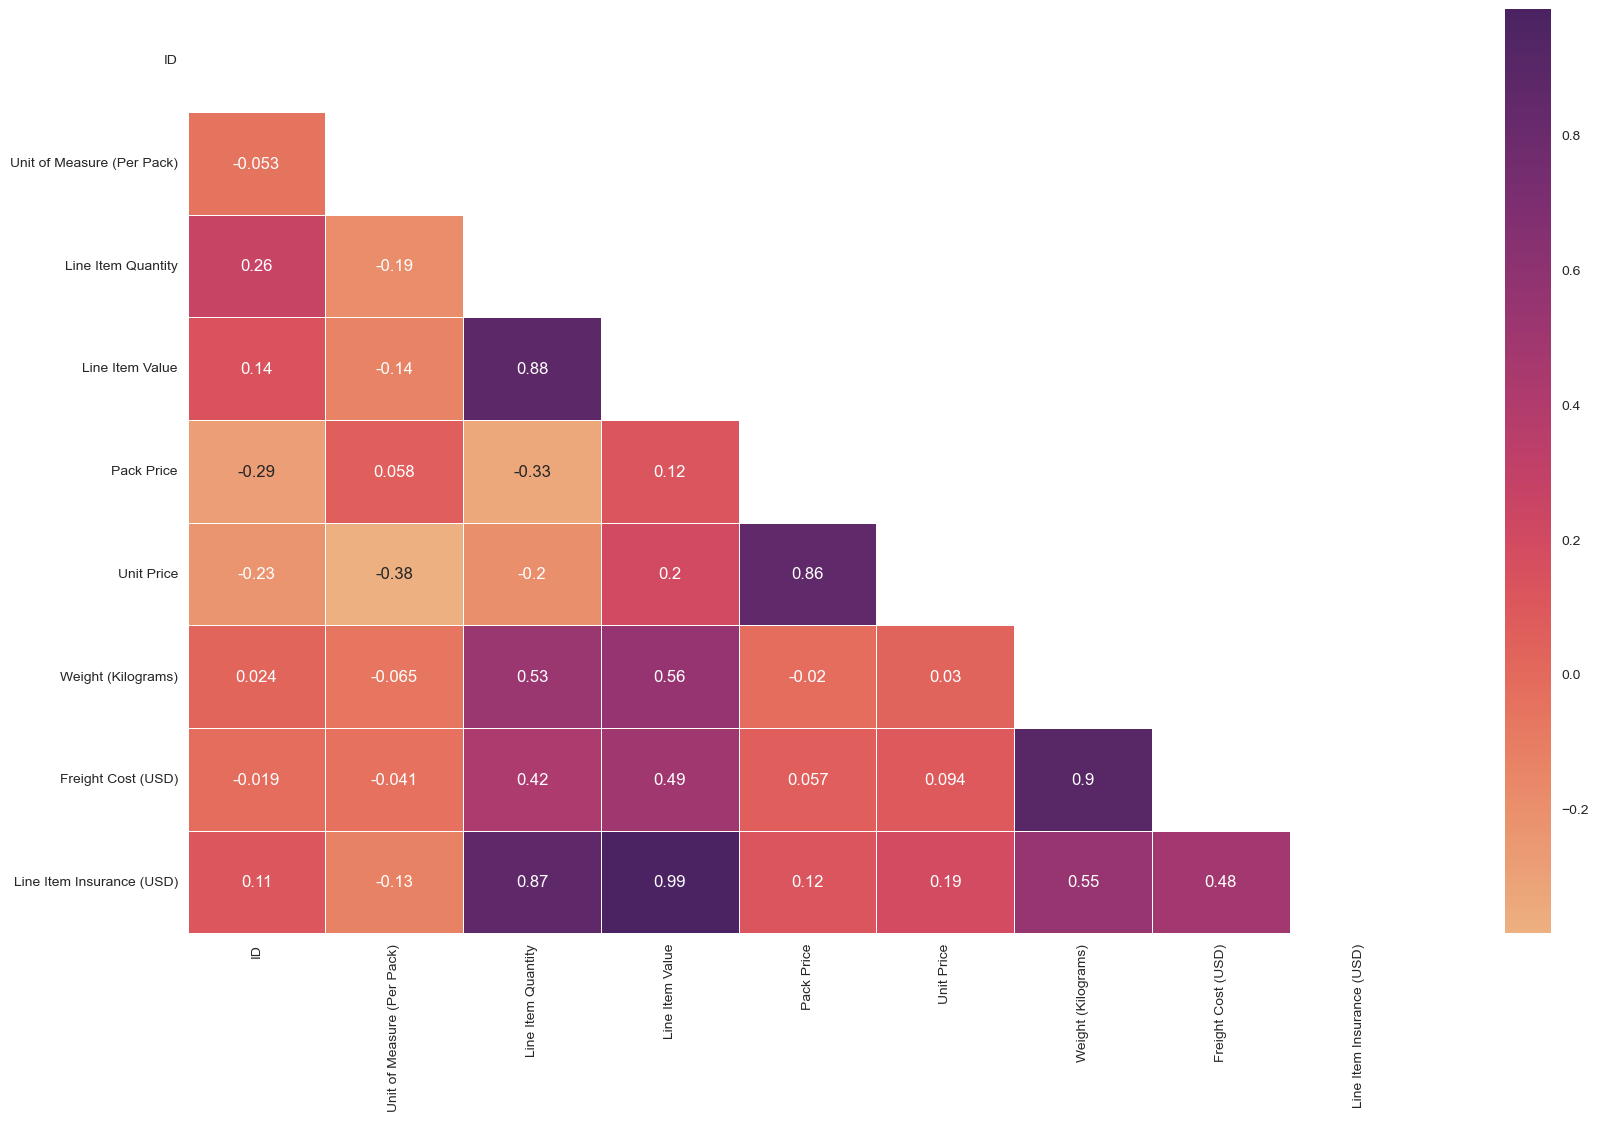

In [54]:
figure(figsize=(20, 12))
mask = np.zeros_like(df.corr('spearman'))
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr('spearman'), annot=True, cmap='flare', linewidths=.5, mask=mask)

## `Drop features`

In [47]:
df.columns

Index(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'Fulfill Via', 'Vendor INCO Term', 'Shipment Mode',
       'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Weight (Kilograms)', 'Freight Cost (USD)',
       'Line Item Insurance (USD)', 'Consiment_price'],
      dtype='object')

In [48]:
df.drop(['ID', 'Project Code', 'PQ #', 'PO / SO #', 'ASN/DN #', 'Country',
       'Managed By', 'PQ First Sent to Client Date', 'PO Sent to Vendor Date',
       'Scheduled Delivery Date', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Item Description', 'Molecule/Test Type', 'Brand', 'Dosage',
       'Dosage Form', 'Unit of Measure (Per Pack)', 'Line Item Quantity',
       'Line Item Value', 'Pack Price', 'Unit Price', 'Manufacturing Site',
       'First Line Designation', 'Freight Cost (USD)', 'Vendor INCO Term',
       'Line Item Insurance (USD)'], axis=1, inplace=True)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10084 entries, 0 to 10323
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fulfill Via         10084 non-null  object 
 1   Shipment Mode       10084 non-null  object 
 2   Weight (Kilograms)  10084 non-null  float64
 3   Consiment_price     10084 non-null  float64
dtypes: float64(2), object(2)
memory usage: 393.9+ KB


In [50]:
df['Shipment Mode'] = df['Shipment Mode'].astype('string')
#df['Vendor INCO Term'] = df['Vendor INCO Term'].astype('string')
df['Fulfill Via'] = df['Fulfill Via'].astype('string')

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10084 entries, 0 to 10323
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Fulfill Via         10084 non-null  string 
 1   Shipment Mode       10084 non-null  string 
 2   Weight (Kilograms)  10084 non-null  float64
 3   Consiment_price     10084 non-null  float64
dtypes: float64(2), string(2)
memory usage: 393.9 KB


### `Ordinal Encoding`

In [52]:
def label_encoding(df, columns=['Shipment Mode', 'Fulfill Via']):
    if (set(columns).issubset(df.columns)):
        label = LabelEncoder()
        for i in columns:
            df[i] = label.fit_transform(df[i])
    return df

In [53]:
label_encoding(df)

,Fulfill Via,Shipment Mode,Weight (Kilograms),Consiment_price
0,0,0,13.0,1331.34
1,0,0,358.0,10721.50
2,0,0,171.0,41653.78
3,0,0,1855.0,143367.86
4,0,0,7590.0,167050.08
...,...,...,...,...
10319,1,4,0.0,600361.39
10320,1,4,0.0,137551.15
10321,1,4,0.0,5145398.78
10322,1,4,1392.0,114005.83


In [54]:
df = pd.get_dummies(df)

In [55]:
df

,Fulfill Via,Shipment Mode,Weight (Kilograms),Consiment_price
0,0,0,13.0,1331.34
1,0,0,358.0,10721.50
2,0,0,171.0,41653.78
3,0,0,1855.0,143367.86
4,0,0,7590.0,167050.08
...,...,...,...,...
10319,1,4,0.0,600361.39
10320,1,4,0.0,137551.15
10321,1,4,0.0,5145398.78
10322,1,4,1392.0,114005.83


### `Feature Scaling`

In [56]:
def feature_scaling(df, columns=['Weight (Kilograms)']):
    if (set(columns).issubset(df.columns)):
        sc = StandardScaler()
        df[columns] = sc.fit_transform(df[columns])
    return df

In [57]:
feature_scaling(df)

,Fulfill Via,Shipment Mode,Weight (Kilograms),Consiment_price
0,0,0,-0.197576,1331.34
1,0,0,-0.165859,10721.50
2,0,0,-0.183051,41653.78
3,0,0,-0.028235,143367.86
4,0,0,0.499004,167050.08
...,...,...,...,...
10319,1,4,-0.198772,600361.39
10320,1,4,-0.198772,137551.15
10321,1,4,-0.198772,5145398.78
10322,1,4,-0.070800,114005.83


In [58]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [59]:
df.columns

Index(['Fulfill Via', 'Shipment Mode', 'Weight (Kilograms)',
       'Consiment_price'],
      dtype='object')

### `Handling skewness of data`

In [60]:
def skewness(df, columns=['Weight (Kilograms)', 'Consiment_price']):
    if (set(columns).issubset(df.columns)):
        df[columns] = np.cbrt(df[columns])
    return df

In [61]:
skewness(df)

,Fulfill Via,Shipment Mode,Weight (Kilograms),Consiment_price
0,0,0,-0.582432,11.000937
1,0,0,-0.549431,22.050504
2,0,0,-0.567794,34.664489
3,0,0,-0.304505,52.338017
4,0,0,0.793173,55.074289
...,...,...,...,...
10319,1,4,-0.583604,84.360197
10320,1,4,-0.583604,51.620405
10321,1,4,-0.583604,172.639305
10322,1,4,-0.413693,48.488902


In [62]:
df.skew()

Fulfill Via          -0.113647
Shipment Mode         0.695789
Weight (Kilograms)    1.688289
Consiment_price       1.004872
dtype: float64

In [63]:
with mlflow.start_run():
    #mlflow.log_artifact('mlruns/output.json')
    mlflow.set_tag("data scientist_1", "kb")
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    Random_forest = RandomForestRegressor(n_estimators=300, max_features=8, random_state=42)
    Random_forest.fit(x_train, y_train)
    y_pred = Random_forest.predict(x_test)
    r2_score_1 = r2_score(y_test, y_pred)
    mlflow.log_metric("r2_score_1", r2_score_1)

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [65]:
models = {
    'Linear_Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(), 
    'ElasticNet': ElasticNet(),
    'Random_Forest': RandomForestRegressor(n_estimators=300, max_features=8),
    'Ada_boost': AdaBoostRegressor(),
    #'Bagging_regressor': BaggingRegressor(),
    'Gradient_Boost': GradientBoostingRegressor(),
    'Decison_tree': DecisionTreeRegressor(), 
    'Extre_tree': ExtraTreeRegressor(),
    #'KNN_neighboure': KNeighborsRegressor(),
    #'MLP_Regressor': MLPRegressor()
    
}

def importnace of features

In [66]:
def train_model(model, model_name, x=x_train, y=y_train, x_test = x_test, y_test = y_test):
    print("------------------------------", model_name , "------------------------------------------")
    model = model.fit(x, y)
    #scores = cross_val_score(model, x, y, cv=10, scoring='neg_mean_squared_error')
    #rmse_scores = np.sqrt(-scores)
    #print("Score_1: ", rmse_scores)
    y_pred = model.predict(x_test)
    residuals = y_test - y_pred
    print("Score", ":", mean_squared_error(y_pred, y_test))
    print("Mean score", ":", np.sqrt(mean_squared_error(y_pred, y_test)))
    #print('Standard deviation: {}'.format(rmse_scores.std()))
    data = pd.DataFrame({"Y_test": y_test , "Y_pred" : y_pred})
    data.head(10)
    viz = FeatureImportances(model)
    viz.fit(x_train, y_train)
    viz.show()
    sns.displot(residuals, kind="kde")
    plt.show()
    visualizer = ResidualsPlot(model, hist=False, qqplot=True)
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.show()
    visualizer_1 = PredictionError(model)
    visualizer_1.fit(x_train, y_train)  
    visualizer_1.score(x_test, y_test)  
    visualizer_1.show()

In [67]:
def train_model_1(model, model_name, x=x_train, y=y_train, x_test = x_test, y_test = y_test):
    print("------------------------------", model_name , "------------------------------------------")
    model = model.fit(x, y)
    y_pred = model.predict(x_test)
    residuals = y_test - y_pred
    r2_score_1 = r2_score(y_test, y_pred)
    #print("Score", ":", mean_squared_error(y_pred, y_test))
    #print("Mean score", ":", np.sqrt(mean_squared_error(y_pred, y_test)))
    #print('Standard deviation: {}'.format(rmse_scores.std()))
    #return data

------------------------------ Linear_Regression ------------------------------------------
Score : 82395981026.33871
Mean score : 287047.0014237019


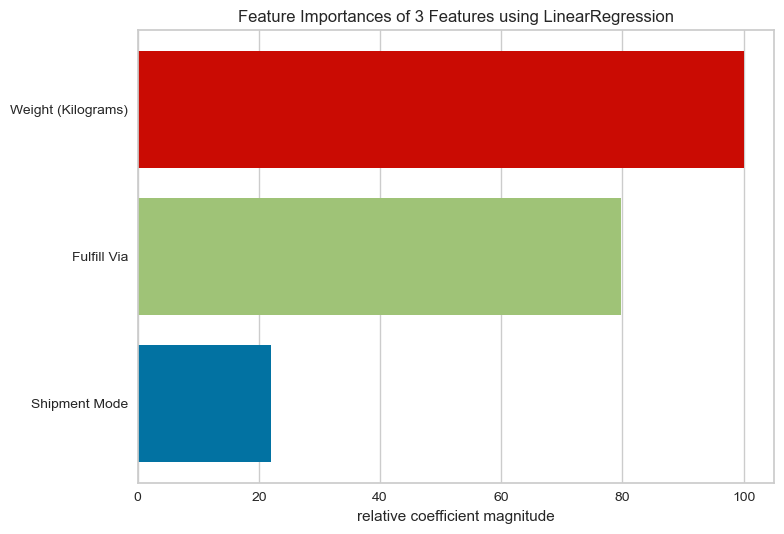

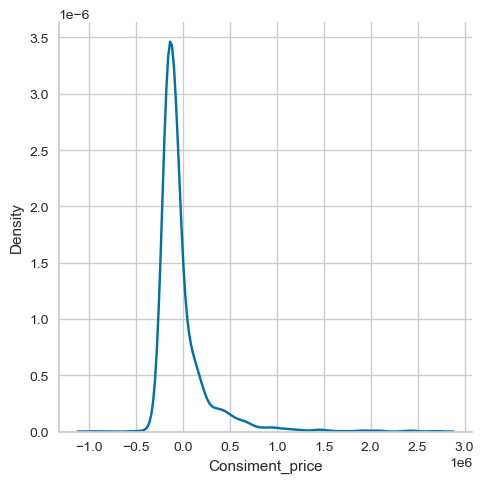

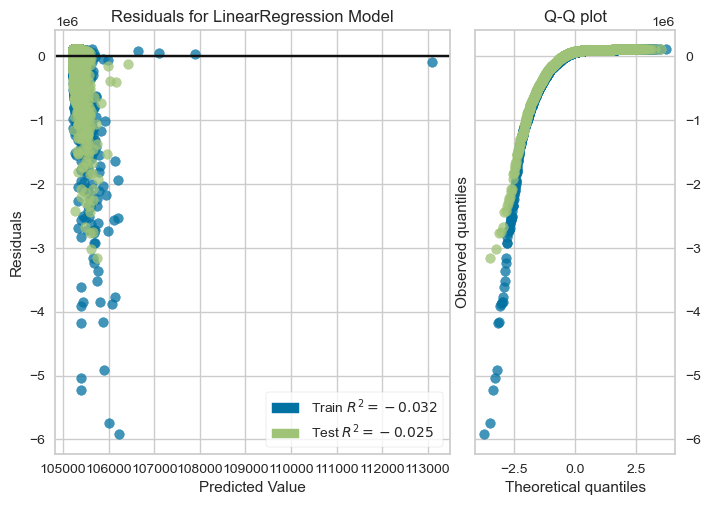

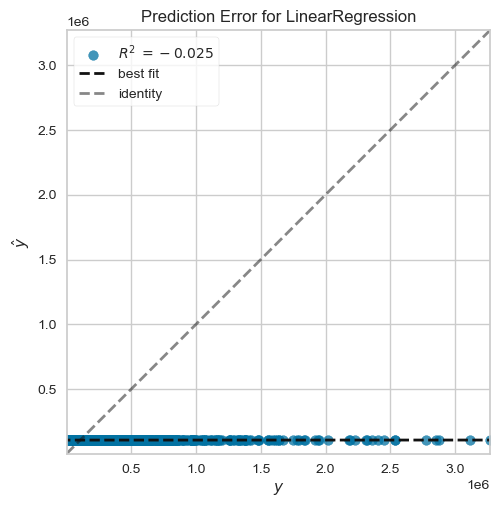

------------------------------ Lasso ------------------------------------------
Score : 82396008900.71837
Mean score : 287047.0499773833


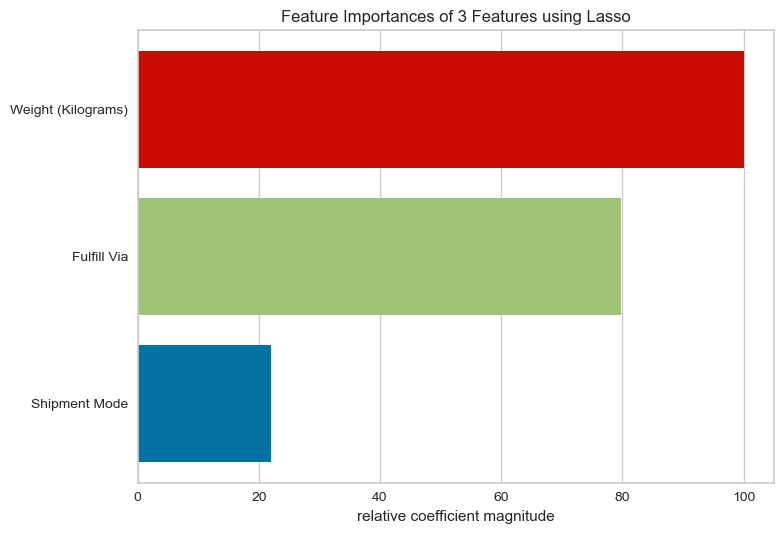

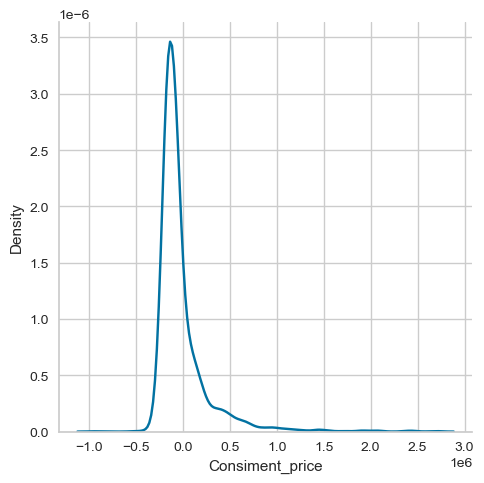

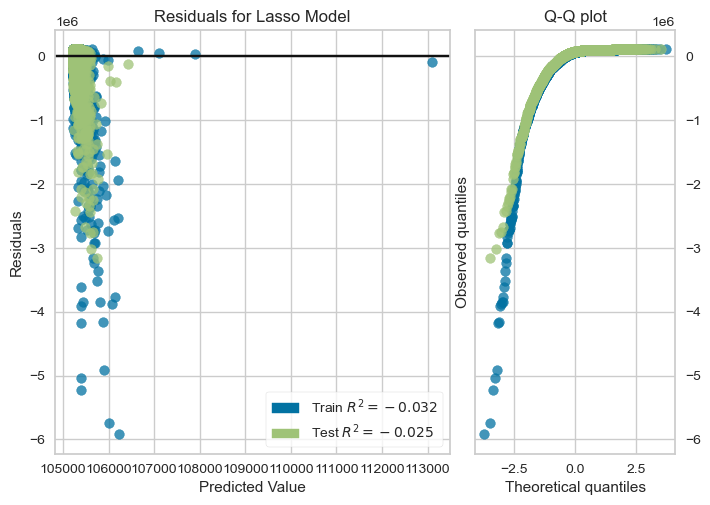

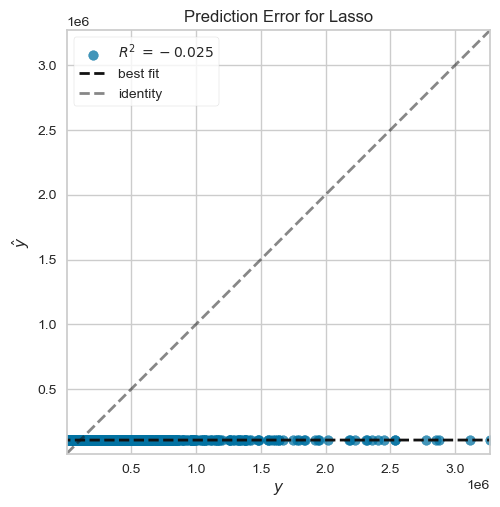

------------------------------ Ridge ------------------------------------------
Score : 82396703642.75783
Mean score : 287048.2601284283


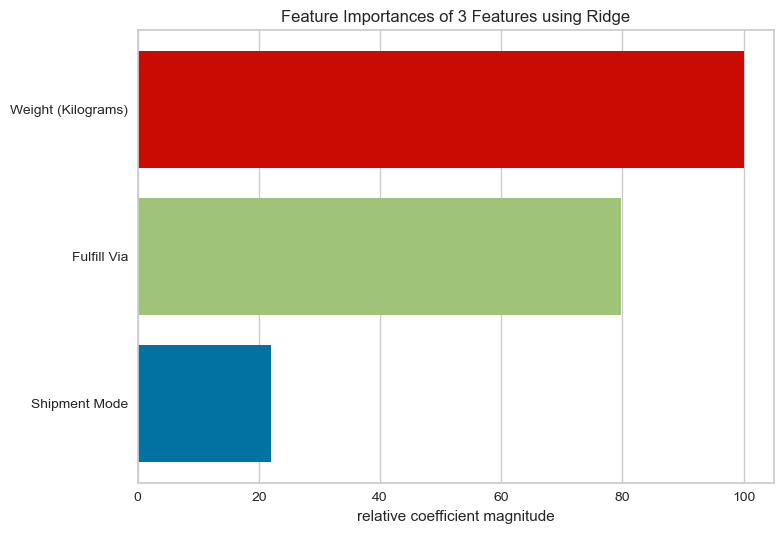

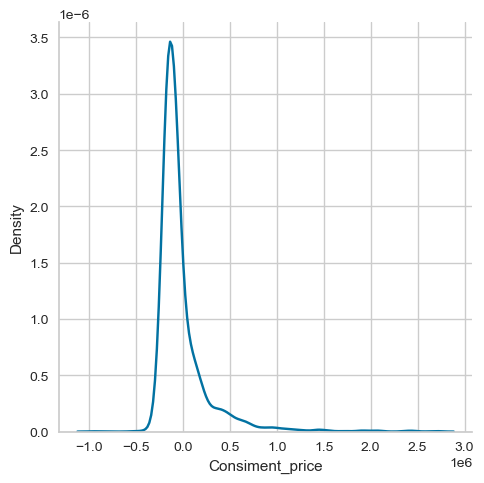

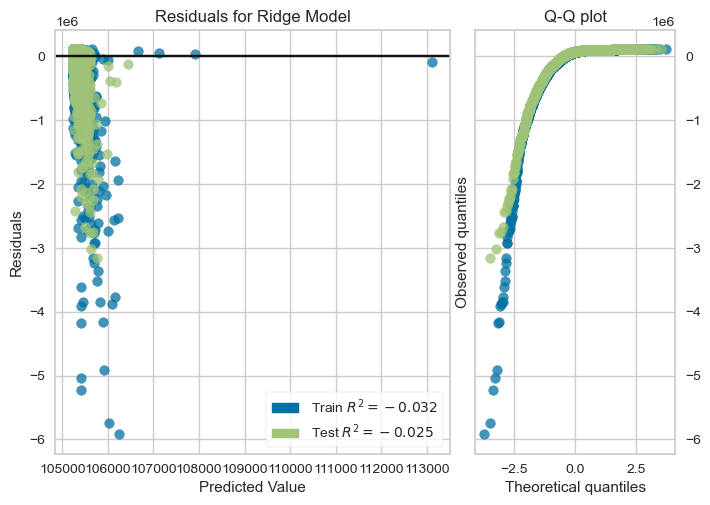

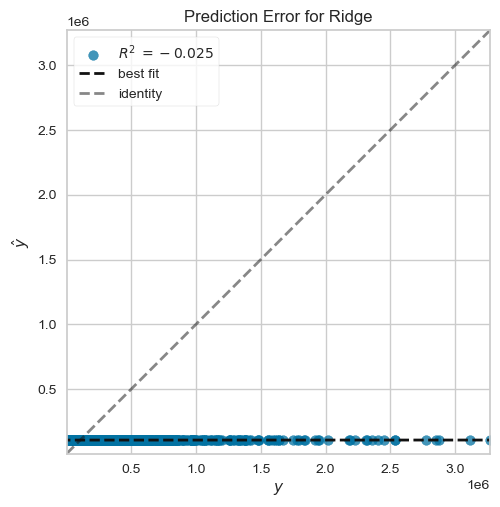

------------------------------ ElasticNet ------------------------------------------
Score : 85555707501.87857
Mean score : 292499.07265131385


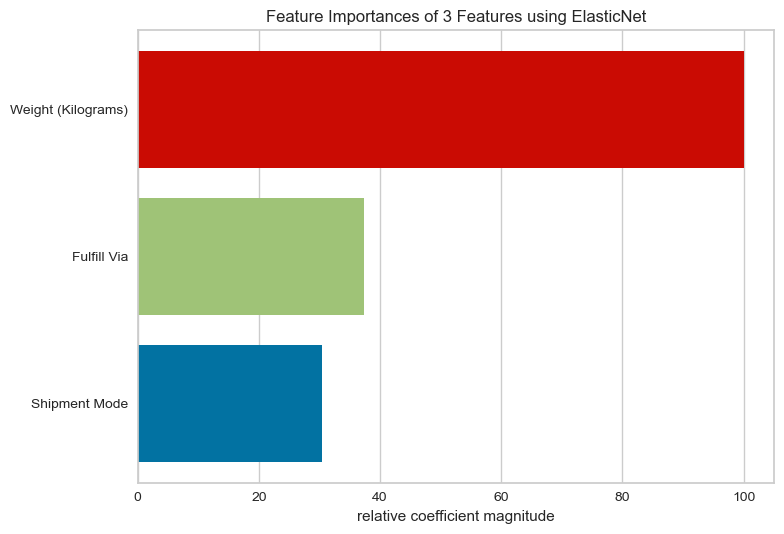

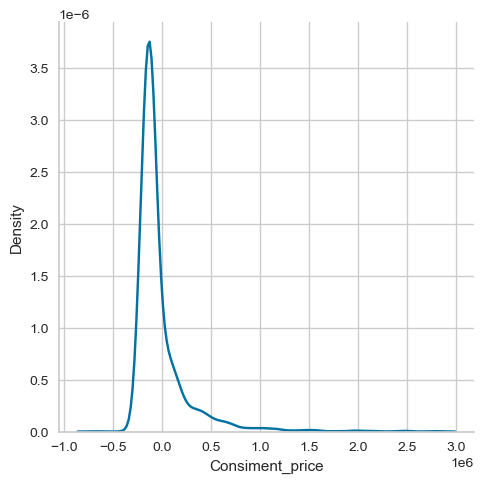

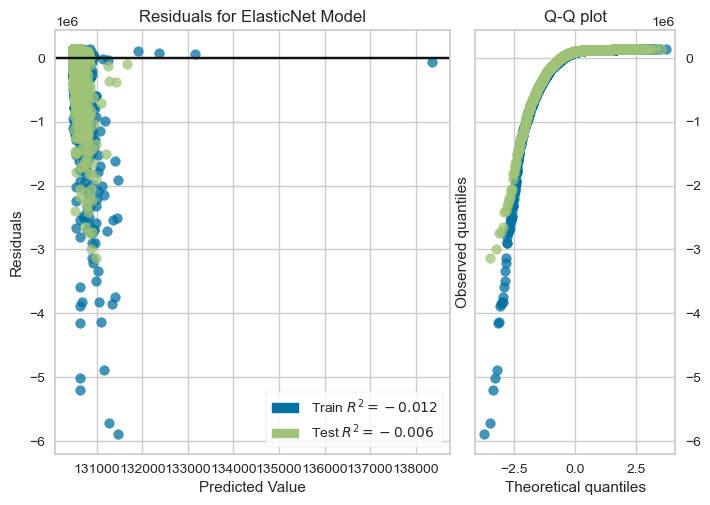

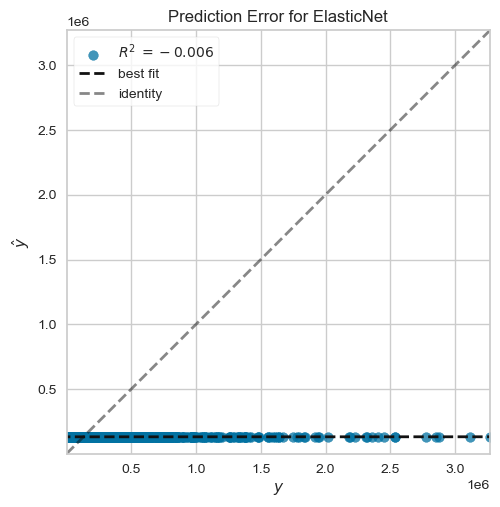

------------------------------ Random_Forest ------------------------------------------
Score : 67892746337.988106
Mean score : 260562.3655441977


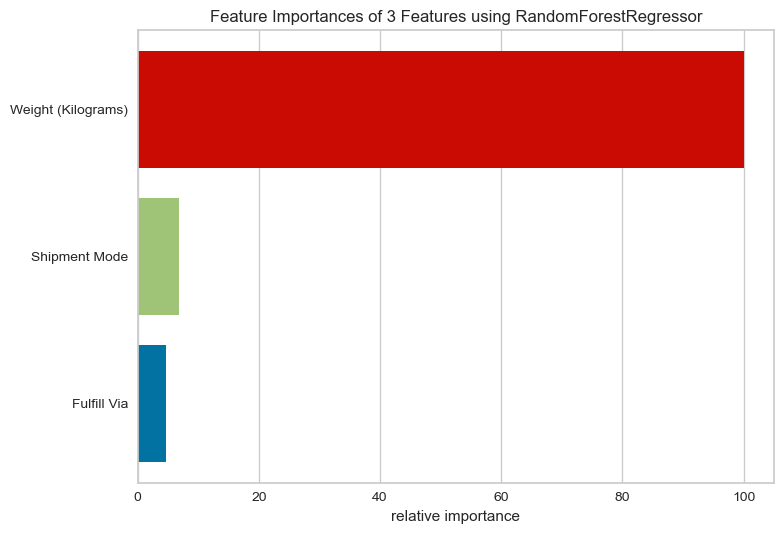

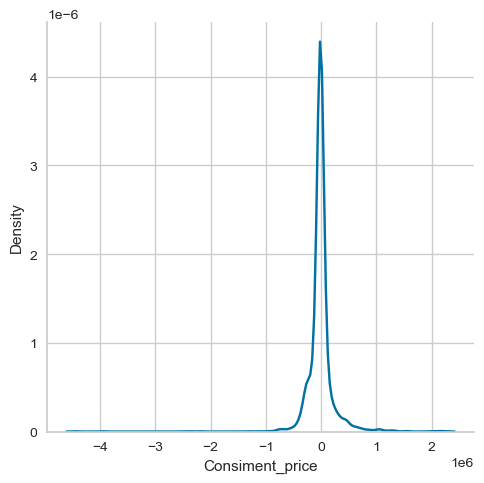

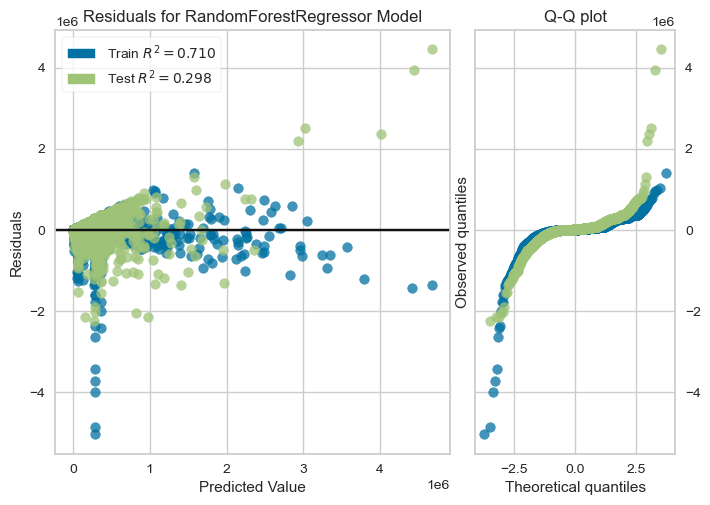

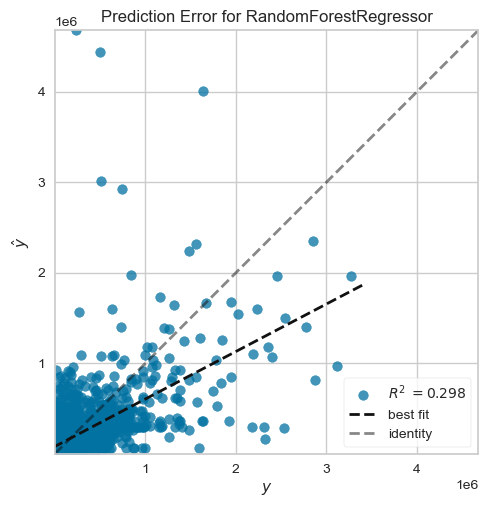

------------------------------ Ada_boost ------------------------------------------
Score : 92897929638.91591
Mean score : 304791.6167464517


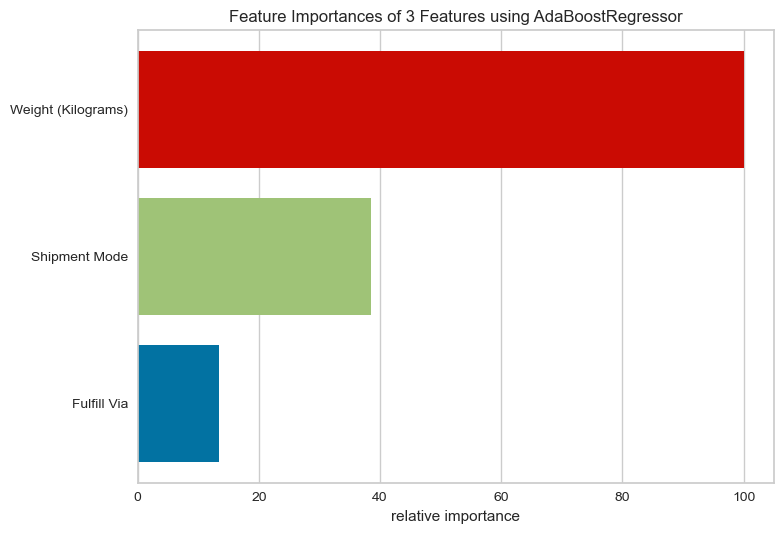

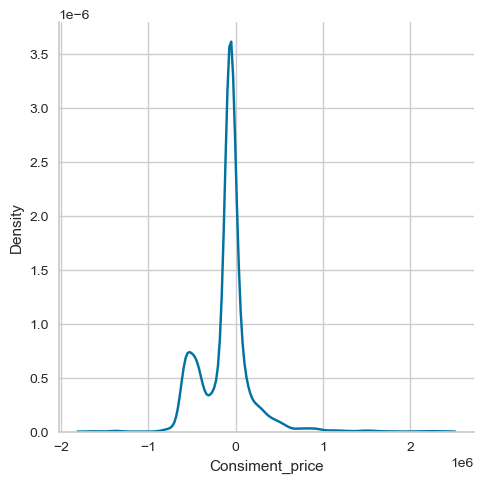

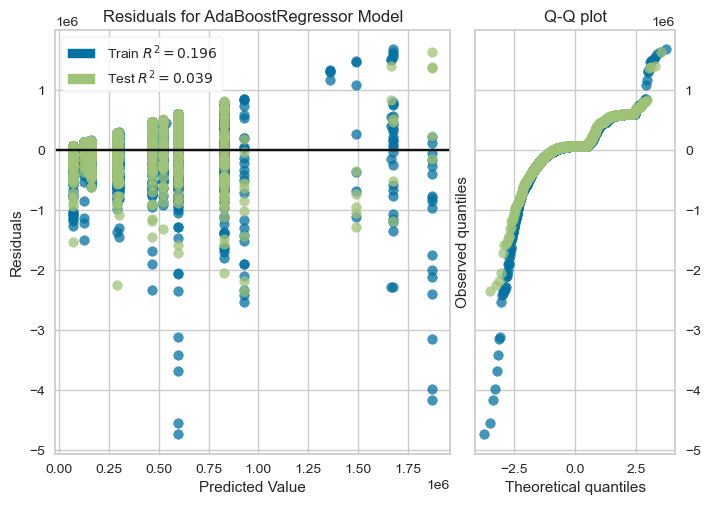

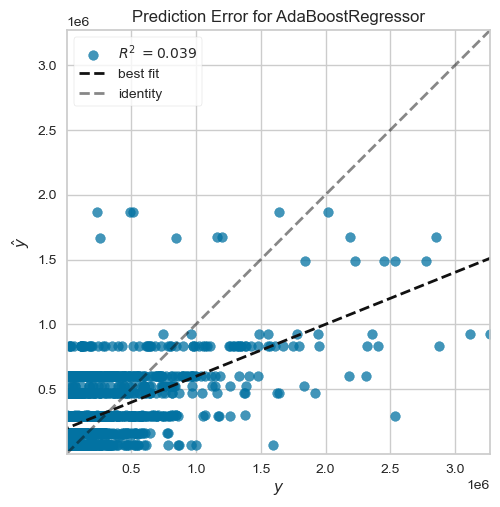

------------------------------ Gradient_Boost ------------------------------------------
Score : 69397090913.36743
Mean score : 263433.27601760457


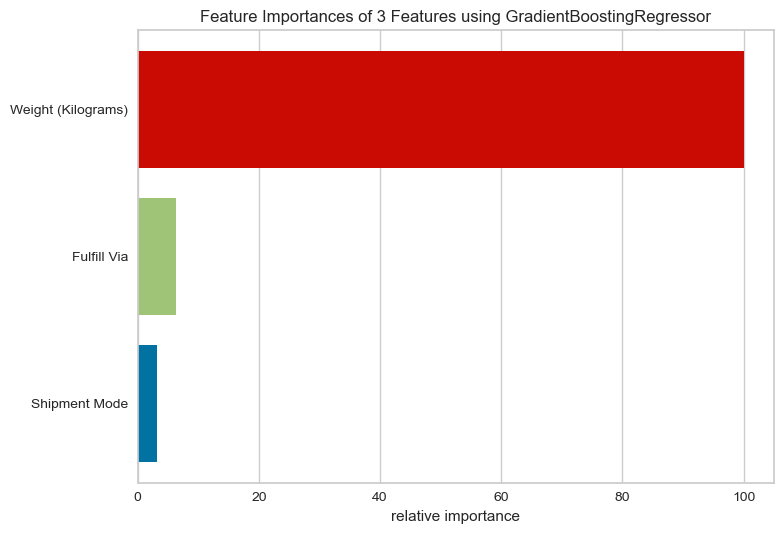

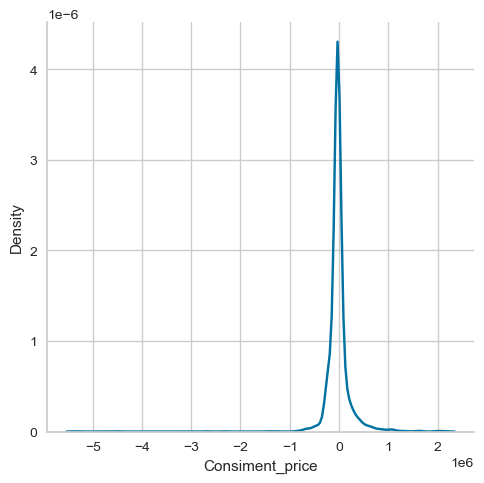

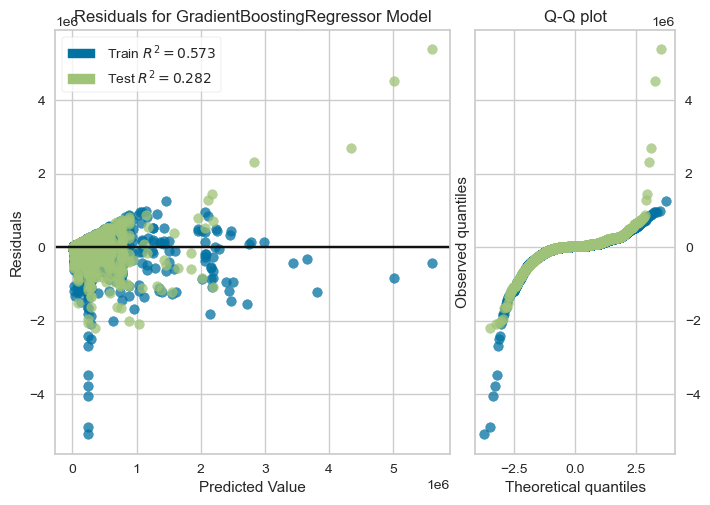

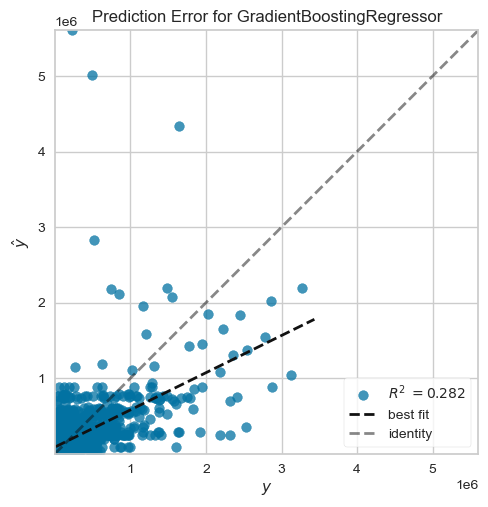

------------------------------ Decison_tree ------------------------------------------
Score : 100927491004.86244
Mean score : 317690.87334209407


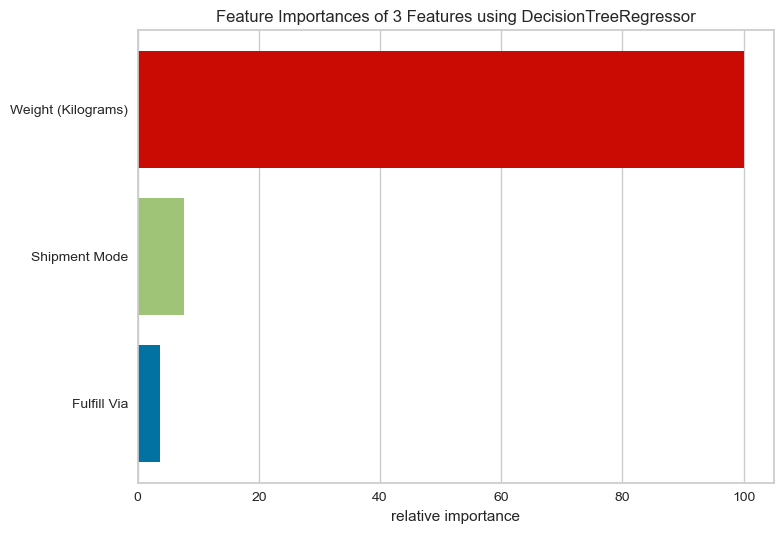

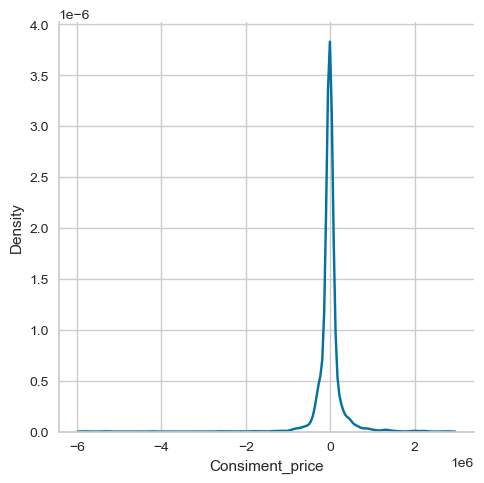

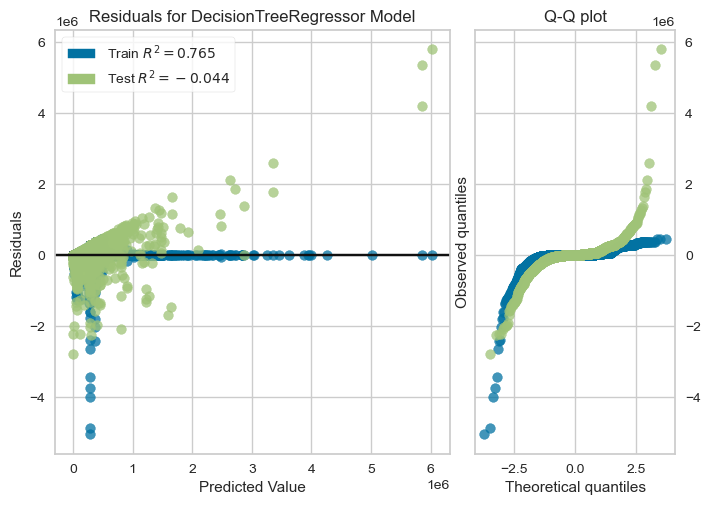

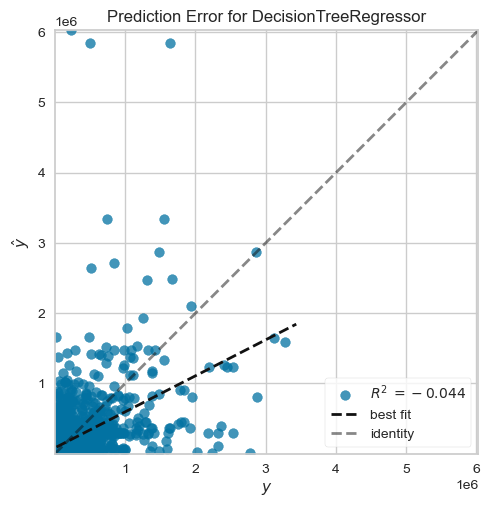

------------------------------ Extre_tree ------------------------------------------
Score : 94844467245.08357
Mean score : 307968.28934986726


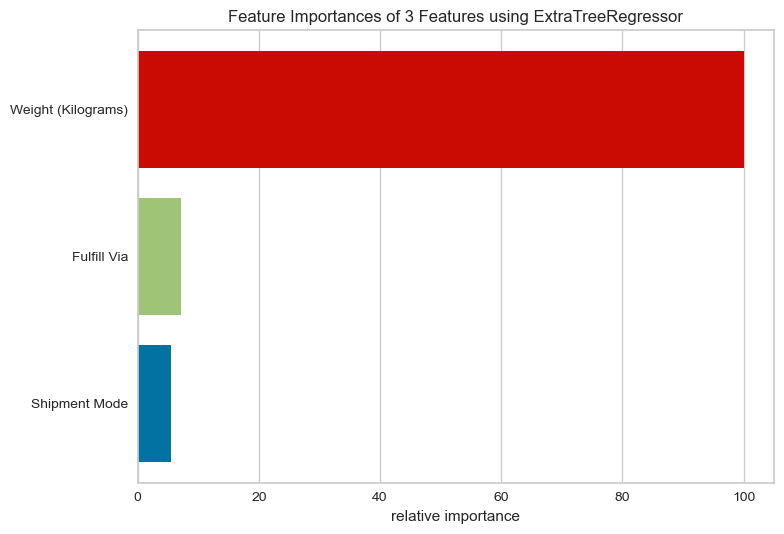

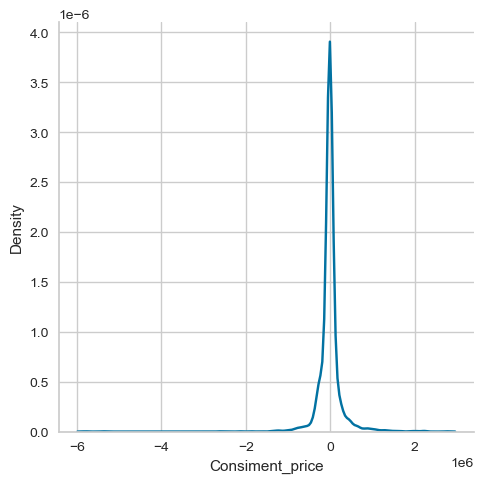

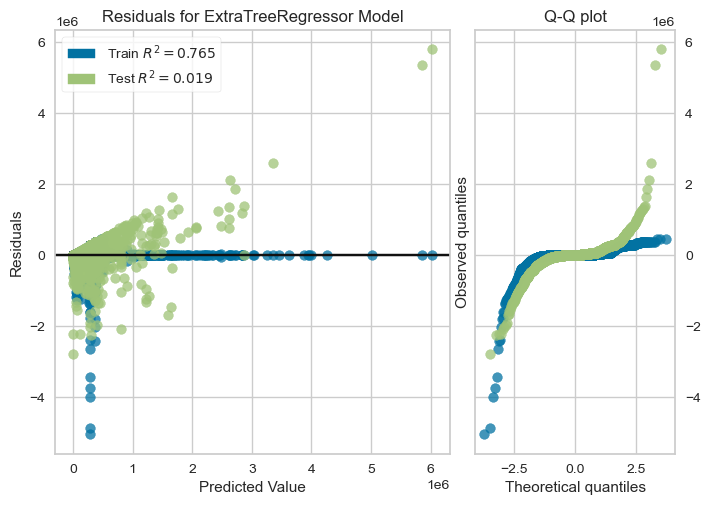

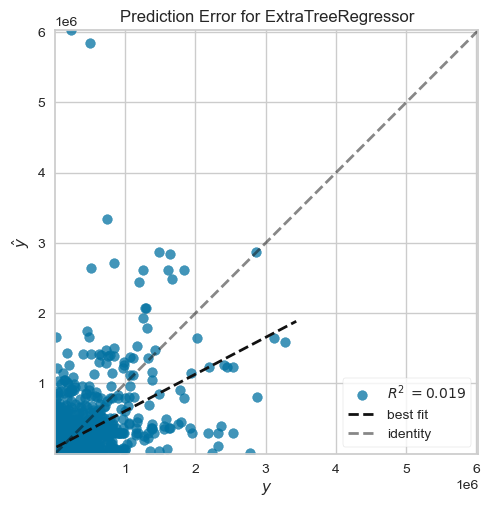

In [68]:
for model_name, model in models.items():
    train_model(model, model_name)

### `Random Forest`

In [69]:
data_clf_random_forest = []
for i in np.linspace(start=50, stop=500, num=10):
    clf_random_forest = RandomForestRegressor(n_estimators=int(i), random_state=0, oob_score=True)
    clf_random_forest.fit(x_train , y_train)
    data_clf_random_forest.append([i, np.array(clf_random_forest.oob_score_)])
    
data_clf_random_forest_dataframe = pd.DataFrame(data_clf_random_forest, columns=["Trees", 'r2_score'])
data_clf_random_forest

[[50.0, array(0.33239981)],
 [100.0, array(0.34260614)],
 [150.0, array(0.35021811)],
 [200.0, array(0.35458842)],
 [250.0, array(0.35444498)],
 [300.0, array(0.35612879)],
 [350.0, array(0.35638322)],
 [400.0, array(0.35378661)],
 [450.0, array(0.35380621)],
 [500.0, array(0.35475208)]]

In [70]:
data_max_feature_clf_random_forest = []
for i in range(1, 8):
    clf_random_forest_max_features = RandomForestRegressor(n_estimators=300, max_features=int(i), random_state=0, oob_score=True)
    clf_random_forest_max_features.fit(x_train, y_train)
    data_max_feature_clf_random_forest.append([i, np.array(clf_random_forest_max_features.oob_score_)])

data_max_feature_clf_random_forest_dataframe = pd.DataFrame(data_max_feature_clf_random_forest, columns=["Trees", 'Accurac'])
data_max_feature_clf_random_forest_dataframe

,Trees,Accurac
0,1,0.32837246861156333
1,2,0.34094950729353524
2,3,0.35612879107065554
3,4,0.35612879107065554
4,5,0.35612879107065554
5,6,0.35612879107065554
6,7,0.35612879107065554


In [71]:
mlflow.sklearn.autolog()

Linear_Regression = LinearRegression()
Lasso= Lasso()
Ridge= Ridge() 
ElasticNet= ElasticNet()
Random_Forest= RandomForestRegressor(n_estimators=300, max_features=8)
Ada_boost= AdaBoostRegressor()
Bagging_regressor= BaggingRegressor()
Gradient_Boost= GradientBoostingRegressor()
Decison_tree= DecisionTreeRegressor() 
Extre_tree= ExtraTreeRegressor()
KNN_neighbour= KNeighborsRegressor()
MLP_Regressor= MLPRegressor()

models = [Linear_Regression, Lasso, Ridge, ElasticNet, Random_Forest, Ada_boost, Bagging_regressor, Gradient_Boost, Decison_tree, Extre_tree, KNN_neighbour, MLP_Regressor]

for model in models: 
    with mlflow.start_run(run_name=f'Run {model}') as run:
        mlflow.set_tag("model", model)
        mlflow.set_tag("data scientist", "kb")
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        r2_score_1 = r2_score(y_test, y_pred)
        mlflow.log_metric("r2_score_1", r2_score_1)